# Stable Diffusion

This notebook is a supplementary material for the Stable Diffusion Chapter of the [Hands-On Generative AI with Transformers and Diffusion Models book](https://learning.oreilly.com/library/view/hands-on-generative-ai/9781098149239/). This notebook includes:

* The code from the book
* Additional examples
* Exercise solutions

## Adding Control: Conditional Diffusion Models


In [3]:
import diffusers
import transformers

transformers.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()

### Preparing the Data


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

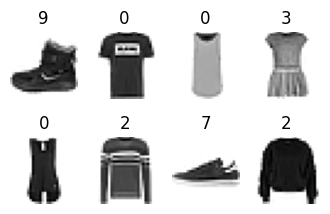

In [3]:
from datasets import load_dataset
from genaibook.core import show_images

import matplotlib as mpl

mpl.rcParams["image.cmap"] = "gray_r"

fashion_mnist = load_dataset("fashion_mnist")
clothes = fashion_mnist["train"]["image"][:8]
classes = fashion_mnist["train"]["label"][:8]
show_images(clothes, titles=classes, figsize=(4, 2.5))

In [5]:
import torch
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Pad(2),  # Add 2 pixels on all sides
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image) for image in examples["image"]]
    return {"images": images, "labels": examples["label"]}


train_dataset = fashion_mnist["train"].with_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True
)

### Creating a Class-Conditioned Model


In [7]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=1,  # 1 channel for grayscale images
    out_channels=1,
    sample_size=32,
    block_out_channels=(32, 64, 128, 256),
    num_class_embeds=10,  # Enable class conditioning
)

In [8]:
x = torch.randn((1, 1, 32, 32))
with torch.inference_mode():
    out = model(x, timestep=7, class_labels=torch.tensor([2])).sample
out.shape

torch.Size([1, 1, 32, 32])

### Training the Model


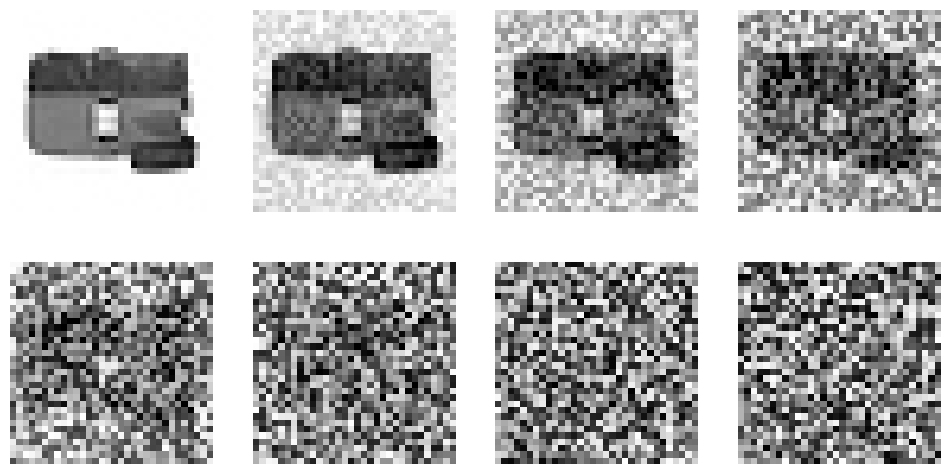

In [9]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)
timesteps = torch.linspace(0, 999, 8).long()
batch = next(iter(train_dataloader))

# We load 8 images from the dataset and
# add increasing amounts of noise to them
x = batch["images"][0].expand([8, 1, 32, 32])
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [10]:
from torch.nn import functional as F
from tqdm import tqdm

from genaibook.core import get_device

# Initialize the scheduler
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02
)

num_epochs = 25
lr = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
losses = []  # To store loss values for plotting

device = get_device()
model = model.to(device)

# Train the model (this takes a while!)
for epoch in (progress := tqdm(range(num_epochs))):
    for step, batch in (
        inner := tqdm(
            enumerate(train_dataloader),
            position=0,
            leave=True,
            total=len(train_dataloader),
        )
    ):
        # Load the input images and classes
        clean_images = batch["images"].to(device)
        class_labels = batch["labels"].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(device)

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device,
        ).long()

        # Add noise to the clean images according
        # to the noise magnitude at each timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        # Note the use of class_labels
        noise_pred = model(
            noisy_images,
            timesteps,
            class_labels=class_labels,
            return_dict=False,
        )[0]

        # Compare the prediction with the actual noise
        loss = F.mse_loss(noise_pred, noise)

        # Update loss display
        inner.set_postfix(loss=f"{loss.cpu().item():.3f}")

        # Store the loss for later plotting
        losses.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 25/25 [24:58<00:00, 59.93s/it]


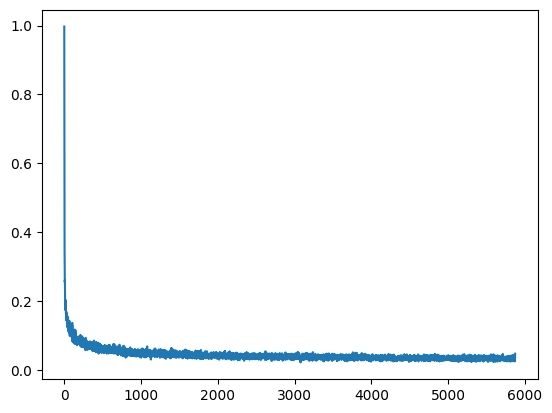

In [31]:
import matplotlib.pyplot as plt

plt.plot(losses);

In [32]:
torch.save(model, "mnist_classcond.pth")

### Sampling

In [33]:
def generate_from_class(class_to_generate, n_samples=8):
    sample = torch.randn(n_samples, 1, 32, 32).to(device)
    class_labels = [class_to_generate] * n_samples
    class_labels = torch.tensor(class_labels).to(device)

    for _, t in tqdm(enumerate(scheduler.timesteps)):
        # Get model prediction
        with torch.inference_mode():
            noise_pred = model(sample, t, class_labels=class_labels).sample

        # Update sample with step
        sample = scheduler.step(noise_pred, t, sample).prev_sample

    return sample.clip(-1, 1) * 0.5 + 0.5

0it [00:00, ?it/s]

1000it [00:13, 71.94it/s]


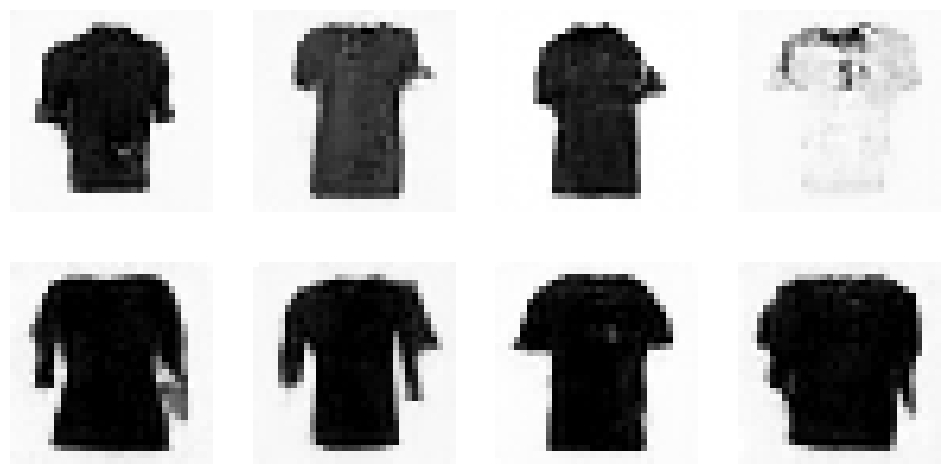

In [34]:
# Generate t-shirts (class 0)
images = generate_from_class(0)
show_images(images, nrows=2)

1000it [00:13, 71.50it/s]


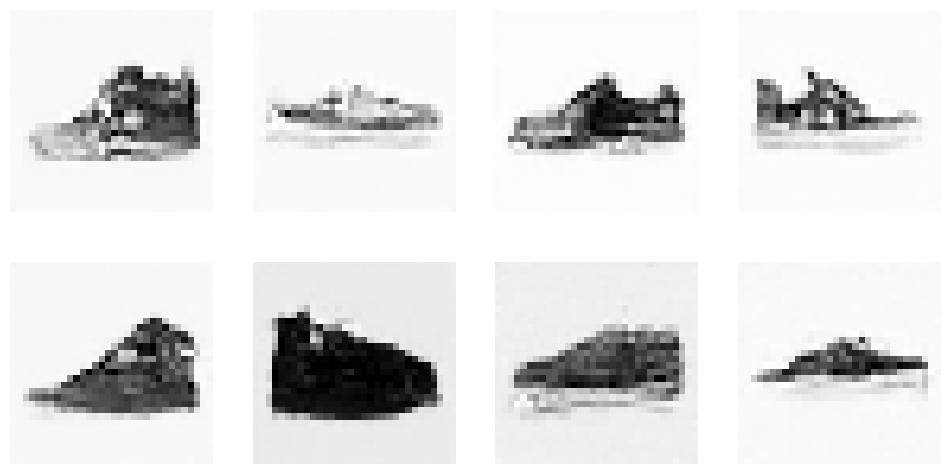

In [35]:
# Now generate some sneakers (class 7)
images = generate_from_class(7)
show_images(images, nrows=2)

1000it [00:14, 70.69it/s]


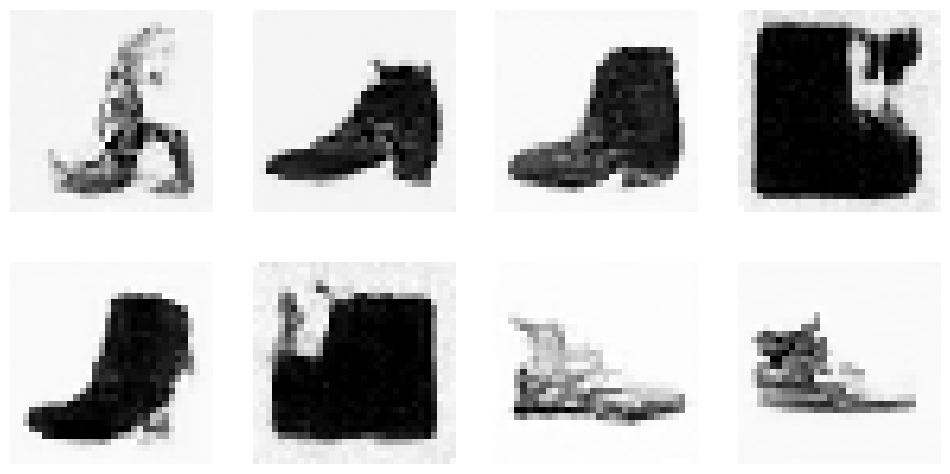

In [36]:
# ...or boots (class 9)
images = generate_from_class(9)
show_images(images, nrows=2)

## Stable Diffusion: Components in Depth

In [3]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 9.77 GiB of which 81.88 MiB is free. Process 124475 has 8.46 GiB memory in use. Including non-PyTorch memory, this process has 454.00 MiB memory in use. Of the allocated memory 230.13 MiB is allocated by PyTorch, and 9.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

  0%|          | 0/50 [00:00<?, ?it/s]

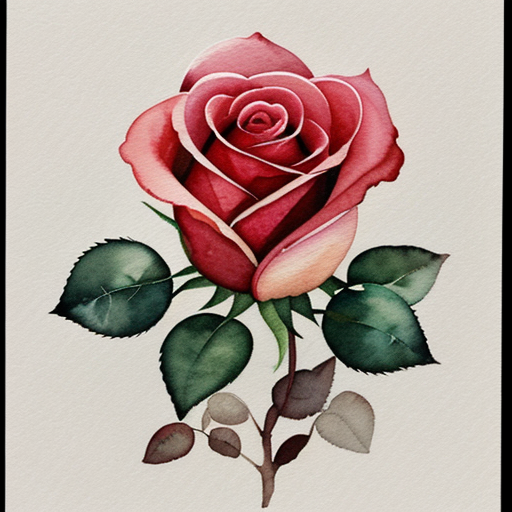

In [7]:
pipe("Watercolor illustration of a rose").images[0]

### The Text Encoder

In [10]:
prompt = "A photograph of a puppy"

# Turn the text into a sequence of tokens:
text_input = pipe.tokenizer(
    prompt,
    return_tensors="pt",
)

# Output each token and its corresponding ID
for t in text_input["input_ids"][0]:
    print(t, pipe.tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(8853) photograph</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>


In [12]:
text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
print("Text embeddings shape:", text_embeddings.shape)

Text embeddings shape: torch.Size([1, 7, 768])


### The VAE


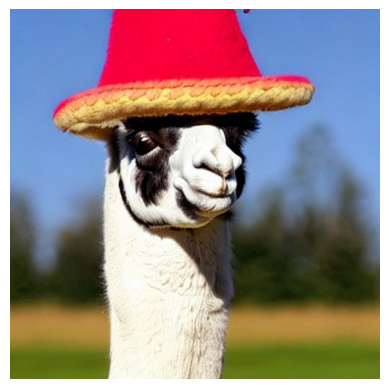

In [15]:
from genaibook.core import load_image, show_image, SampleURL

im = load_image(
    SampleURL.LlamaExample,
    size=(512, 512),
)
show_image(im);

In [19]:
from torchvision import transforms

with torch.inference_mode():
    # Process image
    tensor_im = transforms.ToTensor()(im).unsqueeze(0).to(device) * 2 - 1
    tensor_im = tensor_im.half()

    # Encode the image
    latent = pipe.vae.encode(tensor_im)

    # Sample from the latent distribution
    latents = latent.latent_dist.sample() 
    latents = latents * 0.18215

latents.shape

torch.Size([1, 4, 64, 64])

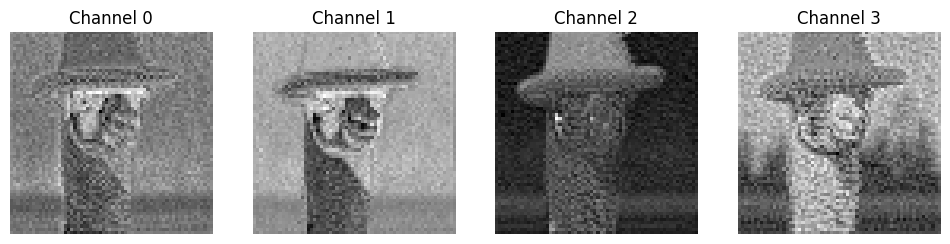

In [23]:
# Plot the individual channels of the latent representation
show_images(
    [l for l in latents[0]],
    titles=[f"Channel {i}" for i in range(latents.shape[1])],
    ncols=4,
)

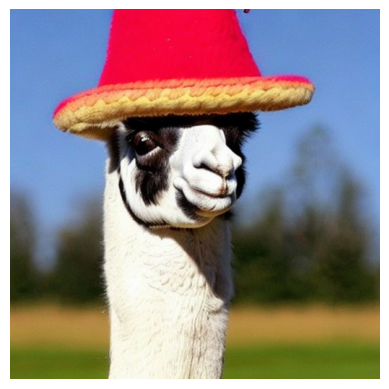

In [26]:
with torch.inference_mode():
    image = pipe.vae.decode(latents / 0.18215).sample
image = (image / 2 + 0.5).clamp(0, 1)
show_image(image[0].float());

### Classifier-free guidance


In [20]:
images = []
prompt = "An oil painting of a collie in a top hat"
for guidance_scale in [1, 2, 4, 12]:
    torch.manual_seed(0)
    image = pipe(prompt, guidance_scale=guidance_scale).images[0]
    images.append(image)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

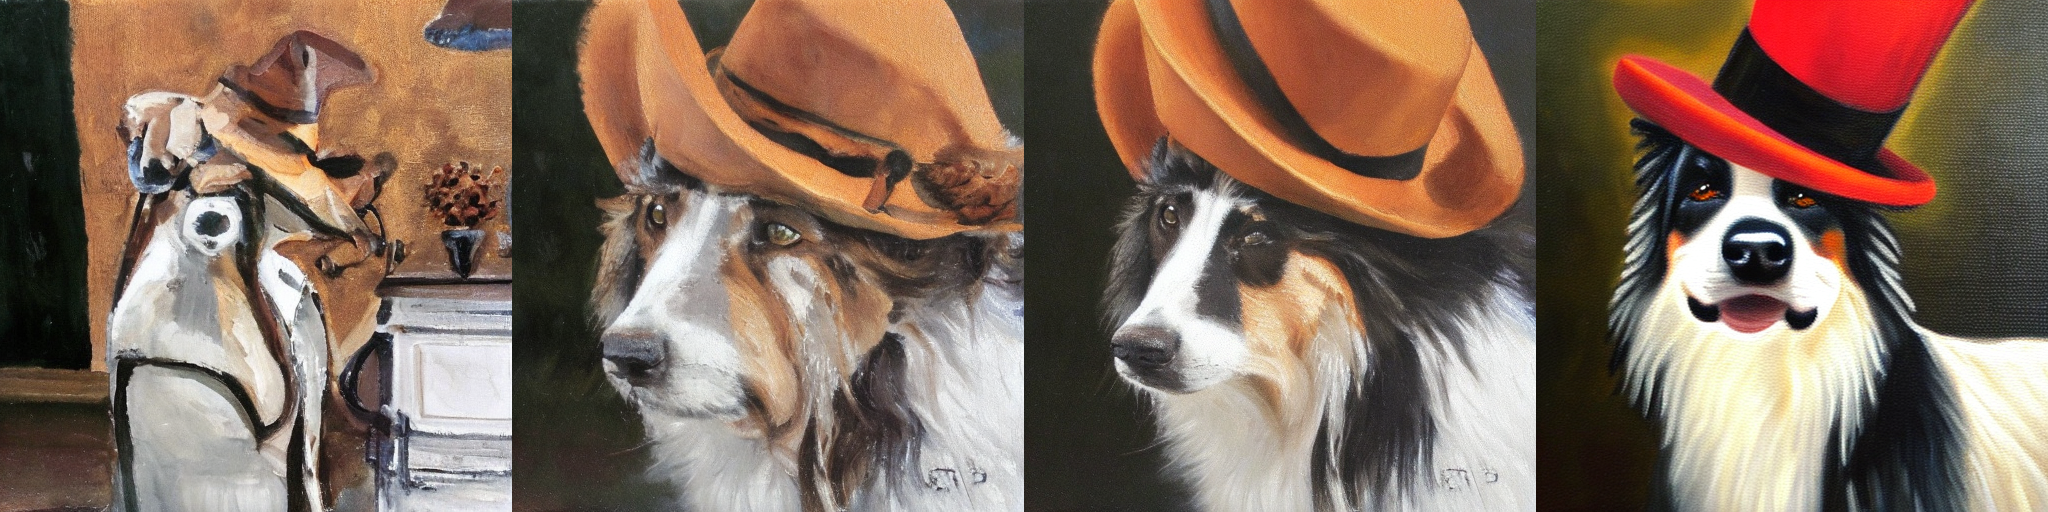

In [21]:
from genaibook.core import image_grid

image_grid(images, 1, 4)

## Putting it All Together: Annotated Sampling Loop


In [44]:
# Some settings
prompt = [
    "Acrylic palette knife painting of a flower"
]  # What we want to generate
height = 512  # default height of SD
width = 512  # default width of SD
num_inference_steps = 30  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
seed = 42  # Seed for random number generator

In [45]:
# Tokenize the input
text_input = pipe.tokenizer(
    prompt,
    padding="max_length",  # Pad to max length to ensure both inputs have the same shape
    return_tensors="pt",
)

# Do the same for the unconditional input (a blank string)
uncond_input = pipe.tokenizer(
    "",
    padding="max_length",
    return_tensors="pt",
)

# Feed both embeddings through the text encoder
with torch.inference_mode():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

# Concatenate the two sets of text embeddings embeddings
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [46]:
# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps)

# Prepare the random starting latents
latents = (
    torch.randn(
        (1, pipe.unet.config.in_channels, height // 8, width // 8),
    )
    .to(device)
    .half()
)
latents = latents * pipe.scheduler.init_noise_sigma

In [47]:
for t in pipe.scheduler.timesteps:
    # Create two copies of the latents to match the two
    # text embeddings (unconditional and conditional)
    latent_input = torch.cat([latents] * 2)
    latent_input = pipe.scheduler.scale_model_input(latent_input, t)

    # Predict noise residuals for both unconditional and conditional latents
    with torch.inference_mode():
        noise_pred = pipe.unet(
            latent_input, t, encoder_hidden_states=text_embeddings
        ).sample

    # Split the prediction into unconditional and conditional versions
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

    # Perform classifier-free guidance
    noise_pred = noise_pred_uncond + guidance_scale * (
        noise_pred_text - noise_pred_uncond
    )

    # Update latents for the next timestep
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

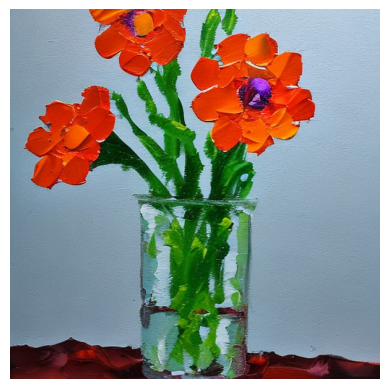

In [48]:
# Scale and decode the image latents with the VAE
latents = 1 / pipe.vae.config.scaling_factor * latents
with torch.inference_mode():
    image = pipe.vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1)

show_image(image[0].float());

## Solutions

A big part of learning is putting your knowledge into practice. We strongly suggest not looking at the solutions before taking a stab at the problem. Scroll down for th answers

### Project Time: Build an interactive ML demo with Gradio

Let's first run the example code to see how it works.

In [ ]:
import gradio as gr


def greet(name):
    return "Hello " + name


demo = gr.Interface(fn=greet, inputs="text", outputs="text")
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Let's now do a demo for Stable Diffusion. We will first load the pipeline and then create a function that receives the input and returns the output.

In [ ]:
import torch
from diffusers import AutoencoderKL, StableDiffusionPipeline

device = get_device()

vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16
).to(device)
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
def generate(prompt):
    return pipe(prompt, num_samples=1).images[0]


demo = gr.Interface(generate, inputs="text", outputs="image")
demo.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


  0%|          | 0/50 [00:00<?, ?it/s]

You can go creative now! Let's add some new features

In [ ]:
def generate(prompt, negative_prompt, num_steps):
    return pipe(
        prompt,
        num_samples=1,
        negative_prompt=negative_prompt,
        num_inference_steps=num_steps,
    ).images[0]


demo = gr.Interface(
    generate,
    inputs=[
        gr.Textbox(
            label="Prompt",
            lines=2,
        ),
        gr.Textbox(
            label="Negative prompt",
            lines=2,
        ),
        gr.Slider(
            minimum=30, maximum=100, step=5, value=50, label="Number of steps"
        ),
    ],
    outputs="image",
    title="Stable Diffusion demo",
)
demo.launch()

Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### Exercises

**1. How does the training process of a class-conditioned diffusion model differ from a nonconditioned model, particularly in terms of the input data and the loss function used?**

The process is almost the same, except that the model is also passed the labels for additional conditioning. The loss function is not affected by this as it's primarily concerned with comparing the generated data with the original noise, regardless of whether conditioning labels are used or not.

**2. How does the timestep embedding influence the quality and evolution of the images during the diffusion process?**

The models from the previous chapter can be seen as a special case of conditioned diffusion model in which the model is conditioned on the timestep. The timestep embedding provides temporal information about the current stage of the diffusion process, which allows the model to generate images that are more coherent and realistic as the diffusion process progresses. As the timestep informs about the level of diffusion that has occurred so far, the model can use this information to generate refined images.

**3. Explain the difference between Latent Diffusion and normal diffusion. What are the trade-offs of using Latent Diffusion?**

Latent diffusion and normal diffusion differ in the space where they operate. Normal diffusion processes directly manipulate pixel values in images, which can be computationally intensive and less scalable, especially for large images. In contrast, latent diffusion operates in a lower-dimensional latent space, often facilitated by a Variational Autoencoder (VAE), making it more scalable and memory-efficient.

The advantages of latent diffusion include reduced memory usage and faster generation times due to its operation in a smaller space. However, there are trade-offs. Latent diffusion models may sacrifice some interpretability compared to normal diffusion models since they operate in a latent space. Additionally, incorporating the VAE component can introduce complexity and potentially make training more challenging.

**4. How is the text prompt incorporated into the model?**

As seen in Chapter 3, CLIP can manage both images and text. To handle text, it uses a text encoder which is a decoder-only transformer as the ones in Chapter 2. This text encoder is used to generate the text prompt embeddings, which are then used to condition the diffusion model by being passed as an additional input, allowing the model to generate images that align with the given text prompt.

**5. What is the difference between model-based and classifier-free guidance? What is the benefit of classifier-free guidance?**

* **Classifier-free guidance:** In this approach, the guidance is provided directly through the diffusion model's conditioning inputs, without relying on a separate classifier model. To achieve this, we combine the generations of conditional and unconditional diffusion models. CFG allows to ensure the text prompt is strongly incorporatd in the generation process. It also removes the need of a separate model.
* **Model-based guidance** refers to the approach of using a separate model, such as a classifier, to guide the generation process. The classifier model is used to calculate the loss, which is incorporated into the inference process.

**6. What is the effect of using a negative prompt? Experiment with it using `pipe(..., negative_prompt="")`. How are you able to guide the image using Stable Diffusion?**

Using a negative prompt allows to guide the image generation process away from a certain attribute or style. For example, if you are generating images of cats and you want to avoid generating black cats, you can use a negative prompt to guide the model away from generating black cats.

**7. Let's say you want to remove white hats from any generated image. How can you use negative prompts for this? First, try implementing this using the high-level pipeline. Then, try adapting the end-to-end inference example. (Hint: it only requires modifying the random part of the classifier-free conditioning).**

Let's first load the model

In [ ]:
import torch
from diffusers import AutoencoderKL, StableDiffusionPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16
).to(device)
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


And let's kick off with an initial image

  0%|          | 0/50 [00:00<?, ?it/s]

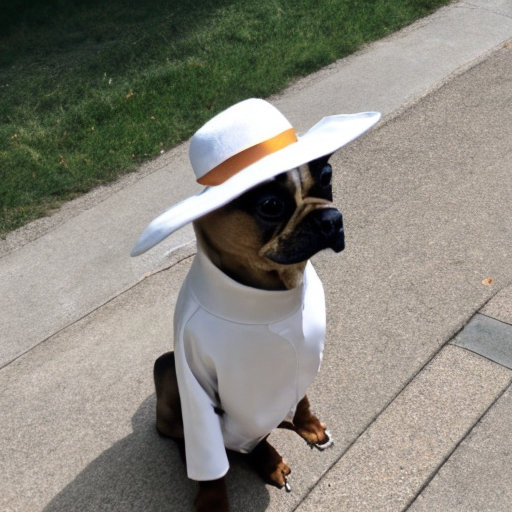

In [ ]:
pipe("A dog wearing a white hat").images[0]

Now let's use a negative prompt to remove the white hat

  0%|          | 0/50 [00:00<?, ?it/s]

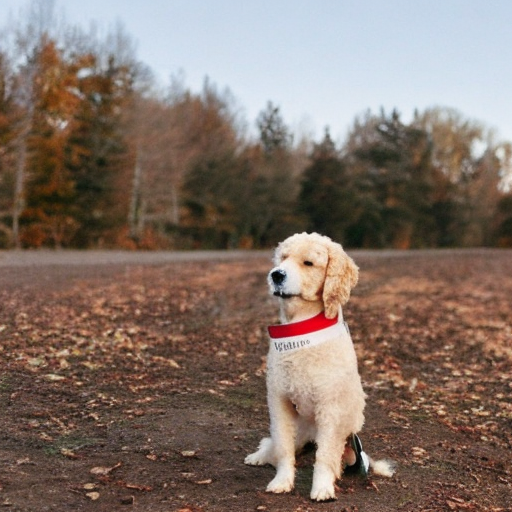

In [ ]:
pipe("A dog wearing a white hat", negative_prompt="a white hat").images[0]

Let's now write the full inference code

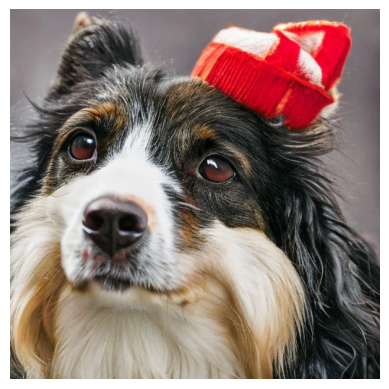

In [ ]:
from genaibook.core import show_image

# Same as before
guidance_scale = 7.5
text_input = pipe.tokenizer(
    "A dog with a white hat",
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)

# This was the only change! Rather than unconditional input, we're using a negative prompt
neg_input = pipe.tokenizer(
    "White hat",
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    return_tensors="pt",
)

with torch.no_grad():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
    neg_prompt_embeddings = pipe.text_encoder(neg_input.input_ids.to(device))[0]

# Concatenate the two sets of text embeddings embeddings
text_embeddings = torch.cat([neg_prompt_embeddings, text_embeddings])

pipe.scheduler.set_timesteps(30)
latents = (
    torch.randn(
        (1, pipe.unet.config.in_channels, 64, 64),
    )
    .to(device)
    .half()
)
latents = latents * pipe.scheduler.init_noise_sigma

for i, t in enumerate(pipe.scheduler.timesteps):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings
        ).sample
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (
        noise_pred_text - noise_pred_uncond
    )
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

latents = 1 / vae.config.scaling_factor * latents
with torch.no_grad():
    image = vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1)
show_image(image[0].float());

**8. What happens in SDXL if you use (256, 256) instead of (1024, 1024) as the "original size" conditioning signal? What happens if you use crop coordinates other than (0, 0)? Can you explain why?**

* If you use crop coordinates of (0, 0), the subject is more likely to be centered in the image. If you use different crop coordinates, the subject will be placed in different positions in the image.
* If you use (256, 256) instead of (1024, 1024) as the "original size" conditioning signal, the model will still generate output images at the default resolution of (1024, 1024). However, they are likely to lack detail and look blurred or upscaled. This is because small images in the training dataset were upscaled during training, and their original size was used as a conditioning signal. Therefore, the model learned what a small but upscaled image looks like. When using the same conditioning signal during inference, the model is likely to produce something that resembles a small upscaled image.

### Challenges

**9. Blue Guidance. Let's say we want to bias generated images to a specific color, such as blue. How can we do that? The first step is to define a conditioning function we'd like to minimize, which, in this case, will be a color loss.**

In [ ]:
def color_loss(images, target_color=(0.1, 0.5, 0.9)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color."""
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    )  # Map target color to (-1, 1)
    target = target[
        None, :, None, None
    ]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(
        images - target
    ).mean()  # Mean absolute difference between the image pixels and the target color
    return error

Given this loss function, write a sampling loop (no training is needed) that modifies _x_ in the direction of the loss function

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

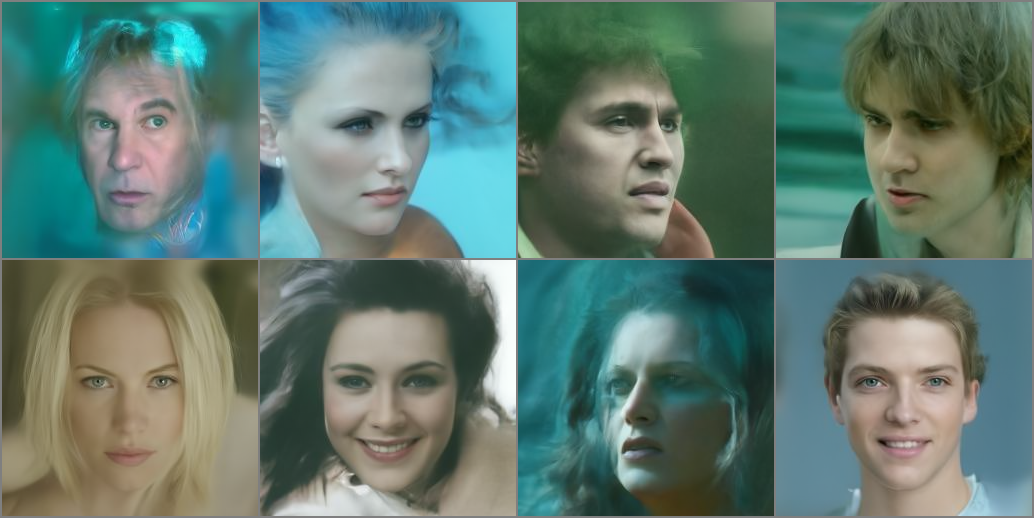

In [ ]:
import numpy as np
import torch
import torchvision
from diffusers import DDPMPipeline
from PIL import Image

# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256").to(device)
pipe.scheduler.set_timesteps(num_inference_steps=30)
guidance_loss_scale = 60  # Try changing this to 5 or 100

# Input setup
x = torch.randn(8, 3, 256, 256).to(device)

# Main loop
for i, t in enumerate(pipe.scheduler.timesteps):
    with torch.no_grad():
        noise_pred = pipe.unet(x, t)["sample"]

    # Set x.requires_grad to True
    x = x.requires_grad_()

    # Get the predicted x0
    scheduler_output = pipe.scheduler.step(
        noise_pred, t, x
    ).pred_original_sample

    # Calculate loss and get gradient
    loss = color_loss(scheduler_output) * guidance_loss_scale
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = pipe.scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))